# Uniform speeds

In [2]:
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_formats = ['svg']

## Scenario

We look at a periodic crossing scenario where all agents share the *same* target speed, configured in the parameter `optimal_speed` in the YAML below.

In [3]:
from navground import sim

scenario = sim.load_scenario("""
type: CrossTorus
agent_margin: 0.1
side: 2
groups:
  -
    type: thymio
    number: 10
    radius: 0.1
    control_period: 0.1
    speed_tolerance: 0.02
    color: [red, green, blue, yellow]
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.12
    behavior:
      type: HL
      horizon: 5.0
      tau: 0.25
      eta: 0.5
      safety_margin: 0.1
      barrier_angle: 1.0
      optimal_speed: 0.12
    state_estimation:
      type: Bounded
      range: 1.0
""")

In the video below, `HL` agents navigate in this scenario: they are colored by the direction they are aiming to.

In [4]:
from navground.sim.ui.video import display_video_from_run, display_video

world = sim.World()
scenario.init_world(world)
display_video(world, time_step=0.1, duration=120.0, relative_margin=0, factor=5, display_width=400)

## Environment

Contrary to the `Cross` scenario used in the [Crossing tutorials](../crossing/index.rst), in this scenario the agents have no target point, just target direction. Therefore we don't include the target distance in the observations.

In [5]:
from navground.learning import ControlActionConfig, DefaultObservationConfig
from navground.learning.parallel_env import shared_parallel_env, make_vec_from_penv
from navground.learning.rewards import SocialReward
from navground.learning import io

sensor = sim.load_state_estimation("""
type: Discs
number: 5
range: 1.0
max_speed: 0.12
max_radius: 0
""")

reward = SocialReward(safety_margin=0.1)
action_config = ControlActionConfig(max_acceleration=1.0, max_angular_acceleration=10.0, 
                                    use_acceleration_action=True)
observation_config = DefaultObservationConfig(include_target_direction=True, include_velocity=True, 
                                              include_angular_speed=True, flat=True)
penv = shared_parallel_env(scenario=scenario, sensor=sensor, action=action_config, 
                           observation=observation_config, reward=reward, 
                           time_step=0.1, max_duration=120)
venv = make_vec_from_penv(penv)
io.save_env(penv, "same_speed_env.yaml")

In [25]:
from navground.learning.evaluation import evaluate_policy

mean = {}
stddev = {}

mean['HL'], stddev['HL'] = evaluate_policy(penv.get_policy(0), venv, n_eval_episodes=100)
print(f"HL reward: {mean['HL'] / 1200: .3f} ± {stddev['HL'] / 1200: .3f}")

HL reward: -0.078 ±  0.040


## Training

In [6]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import VecMonitor
from stable_baselines3.common.logger import configure
from datetime import datetime as dt

stamp = dt.now().strftime("%Y%m%d_%H%M%S")
train_venv = VecMonitor(venv)
sac = SAC("MlpPolicy", train_venv, policy_kwargs={'net_arch': [128, 128]})
sac.set_logger(configure(f'logs/SameSpeed/SAC/{stamp}', ["tensorboard", "csv"]))

In [7]:
sac.learn(total_timesteps=1_000_000, progress_bar=True, log_interval=25, reset_num_timesteps=False)
sac.save(f"SameSpeed/SAC/model")

Output()

The policy is learn in about 700K steps (i.e., 1h of simulated time).

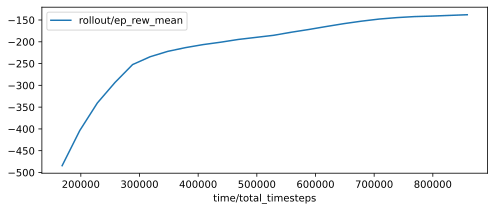

In [9]:
import pandas as pd

df = pd.read_csv(f'{sac.logger.get_dir()}/progress.csv')
df.rolling(window=10).mean().plot(x='time/total_timesteps', y='rollout/ep_rew_mean', figsize=(8, 3));

As usual, we check how well the trained policy performs. First with a video

In [10]:
from navground.learning.evaluation import make_experiment_with_env

exp = make_experiment_with_env(penv, policy=sac.policy)
exp.record_config.pose = True
exp.number_of_runs = 1
exp.steps = 1200
exp.run()
display_video_from_run(exp.runs[0], factor=5, relative_margin=0, display_width=400)

and then by evaluating it to collect the episode rewards

In [26]:
mean['SAC'], stddev['SAC'] = evaluate_policy(sac.policy, venv, n_eval_episodes=100)
print(f"SAC reward: {mean['SAC'] / 1200: .3f} ± {stddev['SAC'] / 1200: .3f}")

SAC reward: -0.135 ±  0.045


In [17]:
pd.set_option("display.precision", 3)
rewards = pd.DataFrame({"mean": mean, "std dev": stddev})
rewards.index = rewards.index.set_names(['algorithm'])
rewards /= 1200
rewards.to_csv("same_speed_rewards.csv")
rewards

mean  std dev
algorithm                
HL        -0.056    0.023
SAC       -0.136    0.034

We also plot the average episode distribution for the two navigation algorithms.

In [20]:
import numpy as np

exp = make_experiment_with_env(penv, policy=sac.policy)
exp.number_of_runs = 30
exp.run()
rewards = np.asarray([run.get_record("reward") for run in exp.runs.values()])
sac_rewards = np.mean(rewards, axis=1)
exp = make_experiment_with_env(penv)
exp.number_of_runs = 30
exp.run()
rewards = np.asarray([run.get_record("reward") for run in exp.runs.values()])
hl_rewards = np.mean(rewards, axis=1)

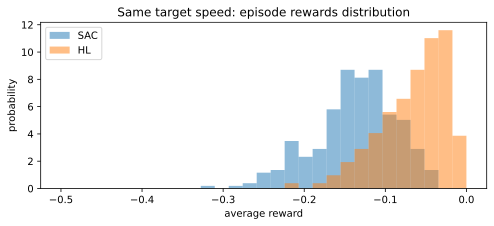

In [30]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 3))
bins = np.linspace(-0.5, 0, 30)
plt.hist(sac_rewards.flatten(), bins=bins, density=True, label="SAC", alpha=0.5);
plt.hist(hl_rewards.flatten(), bins=bins, density=True, label="HL", alpha=0.5);
plt.xlabel('average reward')
plt.ylabel('probability');
plt.title('Same target speed: episode rewards distribution')
plt.legend();

In summary, we have successfully trained a RL policy to navigate in this scenario. Its performance is lower than HL but the behavior of the agents is similarly smooth and predictable.